In [1]:
from pathlib import Path
import numpy as np
from numpy.random import shuffle, seed
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import os
import gc

from xfoil import XFoil
from xfoil.model import Airfoil

from lib.utils import load_pkl, save_pkl
from config import *
from lib.dl_modules import *
from lib.preprocess_modules import interpolate_airfoil, get_alfa_step
from nets.nn import *
from tensorflow.keras.metrics import MeanIoU
from datetime import datetime


# check available resolutions
bitmap_outputs

# create new dataset
create_dataset = False

## Create dataset

In [3]:
if create_dataset:
    
    bitmap_output_number = 1

    # create dataset for selected bitmap output
    pkl_folder = str(bitmap_outputs[bitmap_output_number][0])+'x'+str(bitmap_outputs[bitmap_output_number][1])

    # dataset config
    incl_data = { 'Cl'  : True,
                  'Cd'  : True,
                  'Cm'  : True,
                  'Cp'  : True,
                  'd'   : True,
                  'S'   : True,
                  'Re'  : False,
                  'alfa': False }

    # count samples amount
    samples_amount = len(os.listdir(Path(foils_bmp_path, pkl_folder)))
    # samples_amount = 138

    # count data layers
    n_data_layers = 0
    for key in incl_data.keys():
        if incl_data[key]: n_data_layers+=1       
    
    print('Total samples: %i, layers in sample: %i.' % (samples_amount, n_data_layers))
    print('Taking data from %s folder...' % pkl_folder)

    X = np.zeros((samples_amount, n_data_layers, n_points_Re, n_points_alfa), dtype='float64')
    y = np.zeros((samples_amount, bitmap_outputs[bitmap_output_number][0], bitmap_outputs[bitmap_output_number][1], 1), dtype='int8')

    print('Created empty arrays: X(%s) and y(%s), import data...' % (X.shape, y.shape))

    sample = 0

    for fname in os.listdir(Path(foils_bmp_path, pkl_folder)): 

        if sample>samples_amount-1:break

        if fname not in foil_exception_list:

            foil = load_pkl(Path(foils_pkl_path, fname))

            ind_X=0

            for i, key in enumerate(incl_data):
                if incl_data[key]:
                    X[sample, ind_X, :, :] = foil['X'][i, :, :]
                    ind_X+=1   
            y[sample, :, :, :] = np.expand_dims(load_pkl(Path(foils_bmp_path, pkl_folder, fname)), 2)
            sample+=1

        else:
            print('%s excluded.' % fname)

    # reshaping X 
    X = X.reshape(samples_amount, n_data_layers*n_points_Re*n_points_alfa)

    assert np.sum(np.isnan(X))==0, "NaNs in X"
    assert np.sum(np.isnan(y))==0, "NaNs in y"

    print('Saving...')

    save_pkl(X, Path(dataset_folder, "X.pkl"))
    save_pkl(y, Path(dataset_folder, "y.pkl"))

    del X, y
    gc.collect()

    print('Done.')
    print("Totally foils in arrays: %i" % (sample))

Total samples: 625, layers in sample: 6.
Taking data from 512x512 folder...
Created empty arrays: X((625, 6, 16, 32)) and y((625, 512, 512, 1)), import data...
ea81006.pkl excluded.
ebambino7.pkl excluded.
eiffel428.pkl excluded.
eiffel430.pkl excluded.
goe388.pkl excluded.
goe451.pkl excluded.
goe802a.pkl excluded.
goe802b.pkl excluded.
naca63206.pkl excluded.
naca63a210.pkl excluded.
rc1064c.pkl excluded.
saratov.pkl excluded.
ua79sff.pkl excluded.
Saving...
Done.
Totally foils in arrays: 612


## Load dataset, prepare indices

In [2]:
X = load_pkl(Path(dataset_folder, 'X.pkl'))
y = load_pkl(Path(dataset_folder, 'y.pkl'))
X.shape, y.shape

all_indices = np.arange(len(X))
seed(42)
shuffle(all_indices)

n_indices = len(X)
train_part = int(n_indices*train_percentage)
val_part = int(n_indices*val_percentage)
train_part, val_part
train_indices = all_indices[:train_part]
val_indices = all_indices[train_part:val_part]
test_indices = all_indices[val_part:]

## MSE loss

In [7]:
n_epochs=10000
batch_size=12
lr=1e-3

model=None
history=None

model = ldm_net(X.shape[1], learning_rate=lr, loss='mse', metrics=['mse', MeanIoU(num_classes=2)])
# model = flexi_net(input_vector_size=X.shape[1], output_size=y[0,:,:,0].shape, reg=reg, learning_rate=lr)
# model.load_weights(str(Path("./weights", r_name+'.h5')))#'initial_weights_300foils_04122020.h5')))

# data generators
train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
test_generator  = BatchGenerator(X, y, test_indices, batch_size=1, Xdim=X[0].shape, ydim=y[0].shape, shuffle=False)

# callbacks
early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=1)
lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=10, factor=0.2, patience=10, verbose=1, mode='min')
# lr_reduce = CosineLR(min_lr=1e-12, max_lr=lr, steps_per_epoch=np.ceil(len(train_indices)/batch_size), lr_decay=0.9)
# m_save = ModelCheckpoint(str(Path(results_path, 'weights', 'temp_weights.h5')), monitor='val_mse', 
#                          verbose=0, save_best_only=True, save_weights_only=True, mode='min', period=1)

# train model
history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce],#, m_save],                              
                             verbose=1, workers=1, use_multiprocessing=False)

# save history and weights
# r_name = (str(datetime.now())[:16]).replace(':','-')
# unet.save_weights(str(Path(results_path,'weights', r_name+'.h5')))
# save_pkl(history.history, Path(results_path,'weights', r_name+'.pkl'))

print('Done.')
print("val_MSE: %2.2e, val_IoU: %2.2e" % (np.min(history.history['val_mse']), np.max(history.history['val_mean_io_u'])))

LDM net output shape: (None, 512, 512, 1)
Epoch 1/10000
39/39 [==============================] - 13s 338ms/step - loss: 0.2410 - mse: 0.2410 - mean_io_u: 0.4765 - val_loss: 0.1622 - val_mse: 0.1622 - val_mean_io_u: 0.4773
Epoch 2/10000
39/39 [==============================] - 11s 287ms/step - loss: 0.1995 - mse: 0.1995 - mean_io_u: 0.6863 - val_loss: 0.1138 - val_mse: 0.1138 - val_mean_io_u: 0.4771
Epoch 3/10000
39/39 [==============================] - 11s 287ms/step - loss: 0.1521 - mse: 0.1521 - mean_io_u: 0.8160 - val_loss: 0.0409 - val_mse: 0.0409 - val_mean_io_u: 0.4780
Epoch 4/10000
39/39 [==============================] - 11s 287ms/step - loss: 0.1117 - mse: 0.1117 - mean_io_u: 0.8178 - val_loss: 0.0187 - val_mse: 0.0187 - val_mean_io_u: 0.8724
Epoch 5/10000
39/39 [==============================] - 11s 290ms/step - loss: 0.0778 - mse: 0.0778 - mean_io_u: 0.8177 - val_loss: 0.0201 - val_mse: 0.0201 - val_mean_io_u: 0.8432
Epoch 6/10000
39/39 [==============================] - 11s

39/39 [==============================] - 12s 301ms/step - loss: 0.0092 - mse: 0.0092 - mean_io_u: 0.8638 - val_loss: 0.0102 - val_mse: 0.0102 - val_mean_io_u: 0.8692
Epoch 47/10000
39/39 [==============================] - 11s 285ms/step - loss: 0.0093 - mse: 0.0093 - mean_io_u: 0.8650 - val_loss: 0.0098 - val_mse: 0.0098 - val_mean_io_u: 0.8639
Epoch 48/10000
39/39 [==============================] - 12s 300ms/step - loss: 0.0092 - mse: 0.0092 - mean_io_u: 0.8663 - val_loss: 0.0113 - val_mse: 0.0113 - val_mean_io_u: 0.8272
Epoch 49/10000
39/39 [==============================] - 11s 292ms/step - loss: 0.0092 - mse: 0.0092 - mean_io_u: 0.8633 - val_loss: 0.0099 - val_mse: 0.0099 - val_mean_io_u: 0.8581
Epoch 50/10000
39/39 [==============================] - 11s 292ms/step - loss: 0.0090 - mse: 0.0090 - mean_io_u: 0.8692 - val_loss: 0.0103 - val_mse: 0.0103 - val_mean_io_u: 0.8498
Epoch 51/10000
39/39 [==============================] - 11s 289ms/step - loss: 0.0091 - mse: 0.0091 - mean_io_

39/39 [==============================] - 11s 287ms/step - loss: 0.0047 - mse: 0.0047 - mean_io_u: 0.9356 - val_loss: 0.0076 - val_mse: 0.0076 - val_mean_io_u: 0.9145
Epoch 135/10000
39/39 [==============================] - 11s 288ms/step - loss: 0.0046 - mse: 0.0046 - mean_io_u: 0.9360 - val_loss: 0.0074 - val_mse: 0.0074 - val_mean_io_u: 0.9105
Epoch 136/10000
39/39 [==============================] - 12s 306ms/step - loss: 0.0046 - mse: 0.0046 - mean_io_u: 0.9361 - val_loss: 0.0074 - val_mse: 0.0074 - val_mean_io_u: 0.9149
Epoch 137/10000
39/39 [==============================] - 12s 311ms/step - loss: 0.0046 - mse: 0.0046 - mean_io_u: 0.9365 - val_loss: 0.0071 - val_mse: 0.0071 - val_mean_io_u: 0.9173
Epoch 138/10000
39/39 [==============================] - 12s 311ms/step - loss: 0.0046 - mse: 0.0046 - mean_io_u: 0.9368 - val_loss: 0.0075 - val_mse: 0.0075 - val_mean_io_u: 0.9113
Epoch 139/10000
39/39 [==============================] - 12s 309ms/step - loss: 0.0046 - mse: 0.0046 - mea

39/39 [==============================] - 11s 293ms/step - loss: 0.0045 - mse: 0.0045 - mean_io_u: 0.9396 - val_loss: 0.0074 - val_mse: 0.0074 - val_mean_io_u: 0.9156
Epoch 221/10000
39/39 [==============================] - 11s 294ms/step - loss: 0.0045 - mse: 0.0045 - mean_io_u: 0.9395 - val_loss: 0.0075 - val_mse: 0.0075 - val_mean_io_u: 0.9137
Epoch 222/10000
39/39 [==============================] - 12s 306ms/step - loss: 0.0045 - mse: 0.0045 - mean_io_u: 0.9396 - val_loss: 0.0070 - val_mse: 0.0070 - val_mean_io_u: 0.9186
Epoch 223/10000
38/39 [============================>.] - ETA: 0s - loss: 0.0045 - mse: 0.0045 - mean_io_u: 0.9397
Epoch 00223: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.
39/39 [==============================] - 11s 293ms/step - loss: 0.0045 - mse: 0.0045 - mean_io_u: 0.9396 - val_loss: 0.0073 - val_mse: 0.0073 - val_mean_io_u: 0.9152
Epoch 224/10000
39/39 [==============================] - 12s 298ms/step - loss: 0.0045 - mse: 0.0045 - mean_i

In [8]:
print("val_MSE: %2.2e, val_IoU: %2.2e" % (np.min(history.history['val_mse']), np.max(history.history['val_mean_io_u'])))

val_MSE: 7.00e-03, val_IoU: 9.19e-01


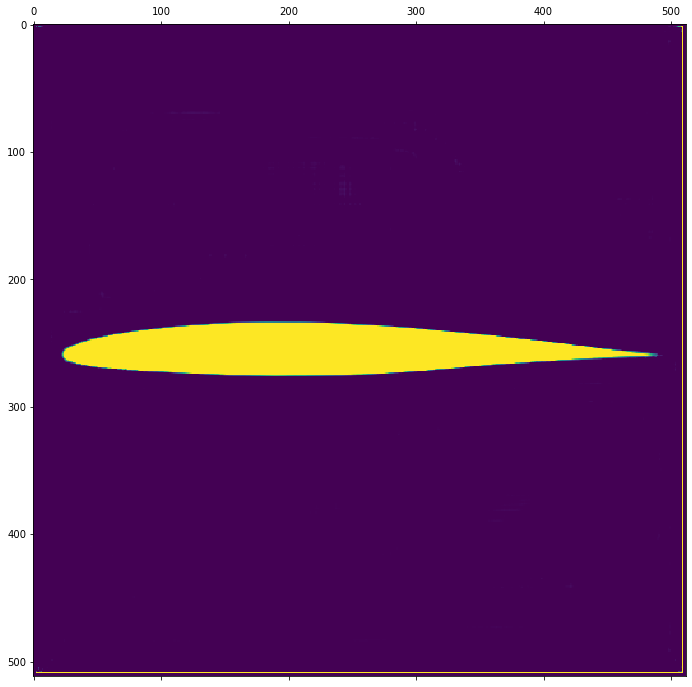

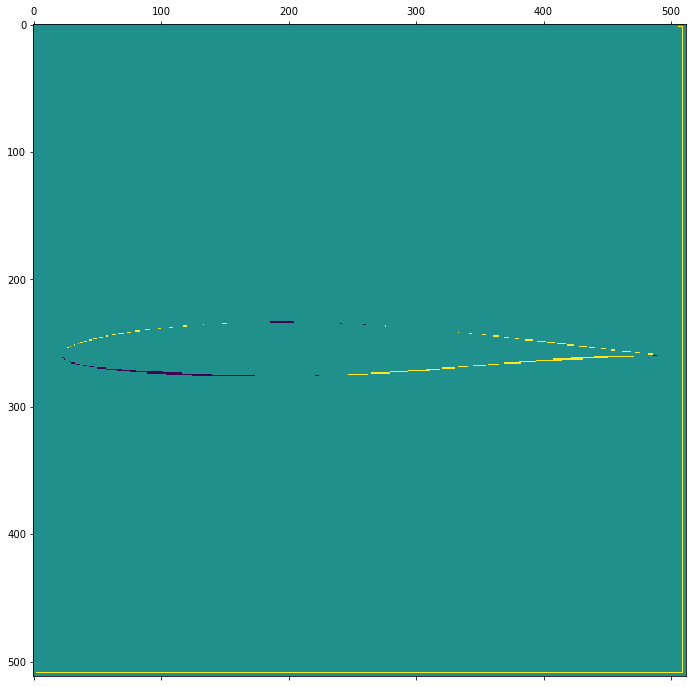

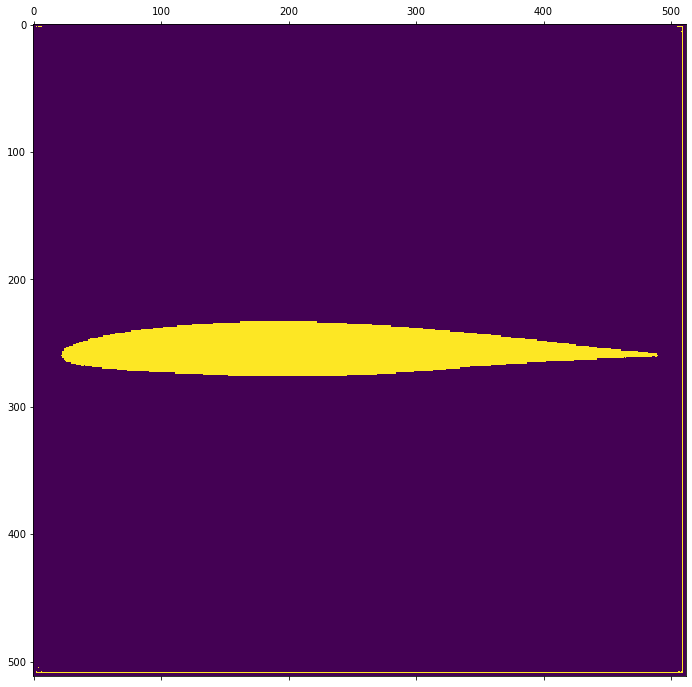

In [9]:
X_test, y_test = test_generator[10]
X_test = np.expand_dims(X_test[0], 0)
y_test = np.expand_dims(y_test[0], 0)

y_pred = model.predict(X_test)

plt.figure(figsize=(12,12))
plt.matshow(y_pred[0,:,:,0],0)

# plt.figure(figsize=(12,12))
# plt.matshow(y_test[0,:,:,0],0)

plt.figure(figsize=(12,12))
plt.matshow((np.round(y_pred[0,:,:,0])-y_test[0,:,:,0]),0)

plt.figure(figsize=(12,12))
y_pred[0,:,:,0][y_pred[0,:,:,0]>0.15]=1
y_pred[0,:,:,0][y_pred[0,:,:,0]<=0.15]=0
plt.matshow(y_pred[0,:,:,0],0)

## Tversky loss

In [52]:
n_epochs=1
batch_size=12
lr=1e-3


model = ldm_net(X.shape[1], learning_rate=lr, loss=tversky_loss, metrics=['mse', MeanIoU(num_classes=2), IoU_var])
# model = flexi_net(input_vector_size=X.shape[1], output_size=y[0,:,:,0].shape, reg=reg, learning_rate=lr)
# model.load_weights(str(Path("./weights", r_name+'.h5')))#'initial_weights_300foils_04122020.h5')))

# data generators
train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
test_generator  = BatchGenerator(X, y, test_indices, batch_size=1, Xdim=X[0].shape, ydim=y[0].shape, shuffle=False)

# callbacks
early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=1)
lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=10, factor=0.2, patience=10, verbose=1, mode='min')
# lr_reduce = CosineLR(min_lr=1e-12, max_lr=lr, steps_per_epoch=np.ceil(len(train_indices)/batch_size), lr_decay=0.9)
# m_save = ModelCheckpoint(str(Path(results_path, 'weights', 'temp_weights.h5')), monitor='val_mse', 
#                          verbose=0, save_best_only=True, save_weights_only=True, mode='min', period=1)

# train model
history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce],#, m_save],                              
                             verbose=1, workers=1, use_multiprocessing=False)

# save history and weights
# r_name = (str(datetime.now())[:16]).replace(':','-')
# unet.save_weights(str(Path(results_path,'weights', r_name+'.h5')))
# save_pkl(history.history, Path(results_path,'weights', r_name+'.pkl'))

print('Done.')
print("val_MSE: %2.2e, val_IoU: %2.2e" % (np.min(history.history['val_mse']), np.max(history.history['val_mean_io_u'])))

39/39 [==============================] - 14s 369ms/step - loss: 0.8318 - mse: 0.2129 - mean_io_u_17: 0.8011 - IoU_var: 0.0099 - val_loss: 0.8375 - val_mse: 0.2414 - val_mean_io_u_17: 0.8223 - val_IoU_var: 0.0055
Done.


KeyError: 'val_mean_io_u'

In [ ]:
X_test, y_test = test_generator[8]
X_test = np.expand_dims(X_test[0], 0)
y_test = np.expand_dims(y_test[0], 0)

y_pred = model.predict(X_test)

plt.figure(figsize=(12,12))
plt.matshow(y_pred[0,:,:,0],0)

# plt.figure(figsize=(12,12))
# plt.matshow(y_test[0,:,:,0],0)

plt.figure(figsize=(12,12))
plt.matshow((np.round(y_pred[0,:,:,0])-y_test[0,:,:,0]),0)

plt.figure(figsize=(12,12))
y_pred[0,:,:,0][y_pred[0,:,:,0]>0.05]=1
y_pred[0,:,:,0][y_pred[0,:,:,0]<=0.05]=0
plt.matshow(y_pred[0,:,:,0],0)

## MSE loss - find best BS

In [24]:
for batch_size in [32,64,128]:
    
    n_epochs=10000    
    lr=1e-3

    model = ldm_net(X.shape[1], learning_rate=lr, loss='mse', metrics=['mse', MeanIoU(num_classes=2)])
    
    train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
    val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
    test_generator  = BatchGenerator(X, y, test_indices, batch_size=1, Xdim=X[0].shape, ydim=y[0].shape, shuffle=False)
    
    early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=1)
    lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=10, factor=0.2, patience=10, verbose=0, mode='min')
    
    history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                                 epochs=n_epochs, callbacks=[early_stop, lr_reduce],#, m_save],                              
                                 verbose=0, workers=1, use_multiprocessing=False)
    
    for key in history.history.keys():
        if 'val_mean_io_u' in key: break    
    
    print('BS=%i, epochs=%i' %(batch_size, len(history.epoch)))
    print("val_MSE: %2.2e, val_IoU: %2.2e" % (np.min(history.history['val_mse']), np.max(history.history[key])))

LDM net output shape: (None, 512, 512, 1)
Restoring model weights from the end of the best epoch.
Epoch 00208: early stopping
BS=32, epochs=208
val_MSE: 2.77e-03, val_IoU: 9.44e-01
LDM net output shape: (None, 512, 512, 1)
Restoring model weights from the end of the best epoch.
Epoch 00228: early stopping
BS=64, epochs=228
val_MSE: 2.85e-03, val_IoU: 9.44e-01
LDM net output shape: (None, 512, 512, 1)


ResourceExhaustedError: OOM when allocating tensor with shape[128,12,508,508] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput] name: ldm_net_16/conv2d_transpose_118/conv2d_transpose/

In [25]:
LDM net output shape: (None, 512, 512, 1)
Restoring model weights from the end of the best epoch.
Epoch 00301: early stopping
BS=2, epochs=301
val_MSE: 5.03e-03, val_IoU: 8.72e-01
LDM net output shape: (None, 512, 512, 1)
Restoring model weights from the end of the best epoch.
Epoch 00214: early stopping
BS=4, epochs=214
val_MSE: 3.48e-03, val_IoU: 9.36e-01
LDM net output shape: (None, 512, 512, 1)
Restoring model weights from the end of the best epoch.
Epoch 00266: early stopping
BS=6, epochs=266
val_MSE: 3.59e-03, val_IoU: 9.37e-01
LDM net output shape: (None, 512, 512, 1)
Restoring model weights from the end of the best epoch.
Epoch 00241: early stopping
BS=8, epochs=241
val_MSE: 3.33e-03, val_IoU: 9.37e-01
LDM net output shape: (None, 512, 512, 1)
Restoring model weights from the end of the best epoch.
Epoch 00234: early stopping
BS=10, epochs=234
val_MSE: 2.90e-03, val_IoU: 9.56e-01
LDM net output shape: (None, 512, 512, 1)
Restoring model weights from the end of the best epoch.
Epoch 00204: early stopping
BS=12, epochs=204
val_MSE: 3.13e-03, val_IoU: 9.49e-01
LDM net output shape: (None, 512, 512, 1)
Restoring model weights from the end of the best epoch.
Epoch 00301: early stopping
BS=16, epochs=301
val_MSE: 3.07e-03, val_IoU: 9.54e-01

SyntaxError: invalid syntax (<ipython-input-25-879f2bbeb942>, line 1)

### Best BS==10

val_MSE: 2.90e-03, val_IoU: 9.56e-01

## Tversky loss - find best BS

Задача: 
- перебрать размеры батчей и определить, как связаны итоговые предикшены с размером батча и IoU_var.
- посмотреть, всегда ли желтые пиксели по краям предикшена.
- выяснить наилучший размер батча для данного лосса.

### Training,  BS=2...128

*Exp1*

In [3]:
for batch_size in [2,4,6,8,10,12,14,16,24,32,64,96,128]:
    
    n_epochs=10000
    lr=1e-3
    verbose=0
    res_dict = {}

    model = ldm_net(X.shape[1], learning_rate=lr, loss=tversky_loss, metrics=['mse', MeanIoU(num_classes=2), IoU_var])
    
    train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
    val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
    test_generator  = BatchGenerator(X, y, test_indices, batch_size=1, Xdim=X[0].shape, ydim=y[0].shape, shuffle=False)
    
    early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=verbose)
    lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=10, factor=0.2, patience=10, verbose=verbose, mode='min')
    
    history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                                 epochs=n_epochs, callbacks=[early_stop, lr_reduce],#, m_save],                              
                                 verbose=verbose, workers=1, use_multiprocessing=False)
    
    for key in history.history.keys():
        if 'val_mean_io_u' in key: break  
            
    best_epoch = np.argmin(history.history['loss'])
    
    res_dict[batch_size] = history.history
    
    print('BS=%i, epochs=%i' %(batch_size, len(history.epoch)))
    print("val_MSE: %2.2e, val_IoU: %2.2e, val_IoU_var: %2.2e" % ((history.history['val_mse'][best_epoch]), history.history[key][best_epoch], history.history['val_IoU_var'][best_epoch]))
    print('---------------------------------------------------------')
    
    # save history and weights
    r_name = 'Exp1 BS='+str(batch_size)+"_"+(str(datetime.now())[:16]).replace(':','-')
    model.save_weights(str(Path('weights', r_name+'.h5')))
    save_pkl(res_dict, Path('weights', r_name+'.pkl'))

BS=2, epochs=345
val_MSE: 6.94e-03, val_IoU: 9.23e-01, val_IoU_var: 1.38e-02
---------------------------------------------------------
BS=4, epochs=347
val_MSE: 5.17e-03, val_IoU: 9.42e-01, val_IoU_var: 1.80e-02
---------------------------------------------------------
BS=6, epochs=344
val_MSE: 4.63e-03, val_IoU: 9.47e-01, val_IoU_var: 2.18e-02
---------------------------------------------------------
BS=8, epochs=388
val_MSE: 4.82e-03, val_IoU: 9.45e-01, val_IoU_var: 2.19e-02
---------------------------------------------------------
BS=10, epochs=404
val_MSE: 9.12e-03, val_IoU: 9.05e-01, val_IoU_var: 2.12e-02
---------------------------------------------------------
BS=12, epochs=548
val_MSE: 4.42e-03, val_IoU: 9.50e-01, val_IoU_var: 1.28e-02
---------------------------------------------------------
BS=14, epochs=344
val_MSE: 4.71e-03, val_IoU: 9.46e-01, val_IoU_var: 2.29e-02
---------------------------------------------------------
BS=16, epochs=280
val_MSE: 3.73e-03, val_IoU: 9.56e-

ResourceExhaustedError: OOM when allocating tensor with shape[96,12,508,508] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

Смотрим, что создалось:

### View results

In [4]:
for f in os.listdir('weights'): 
    if '.pkl' in f and 'Exp' in f: print(f)
print()
for f in os.listdir('weights'): 
    if '.h5' in f and 'Exp' in f: print(f)

Exp1 BS=10_2021-03-23 21-37.pkl
Exp1 BS=12_2021-03-24 00-02.pkl
Exp1 BS=14_2021-03-24 01-29.pkl
Exp1 BS=16_2021-03-24 02-37.pkl
Exp1 BS=24_2021-03-24 03-53.pkl
Exp1 BS=2_2021-03-23 13-56.pkl
Exp1 BS=32_2021-03-24 04-51.pkl
Exp1 BS=4_2021-03-23 16-06.pkl
Exp1 BS=64_2021-03-24 05-41.pkl
Exp1 BS=6_2021-03-23 17-56.pkl
Exp1 BS=8_2021-03-23 19-48.pkl

Exp1 BS=10_2021-03-23 21-37.h5
Exp1 BS=12_2021-03-24 00-02.h5
Exp1 BS=14_2021-03-24 01-29.h5
Exp1 BS=16_2021-03-24 02-37.h5
Exp1 BS=24_2021-03-24 03-53.h5
Exp1 BS=2_2021-03-23 13-56.h5
Exp1 BS=32_2021-03-24 04-51.h5
Exp1 BS=4_2021-03-23 16-06.h5
Exp1 BS=64_2021-03-24 05-41.h5
Exp1 BS=6_2021-03-23 17-56.h5
Exp1 BS=8_2021-03-23 19-48.h5


In [41]:
results = np.zeros((11,3))
n_rec=0
for fname in os.listdir('weights'): 
    if '.pkl' in fname and 'Exp' in fname:
        bs = int(((fname.split(' ')[1][:5]).split("=")[1][:2]).replace('_',''))
        res_dict = load_pkl(Path('weights', fname))
        for key in (res_dict[bs]).keys():
            if 'val_mean_io_u' in key: break
        best_ep = np.argmax(res_dict[bs][key])
#         print(best_ep)
        best_ep = np.argmin(res_dict[bs]['val_loss'])
#         print(best_ep)
#         print('---------------')
        results[n_rec,:] = bs, res_dict[bs][key][best_ep], res_dict[bs]['val_IoU_var'][best_ep]
        n_rec+=1#print(bs, '::', res_dict[bs][key][best_ep], res_dict[bs]['val_IoU_var'][best_ep])   # res_dict[bs]['val_mse'][best_ep],      
results.sort(axis=0)

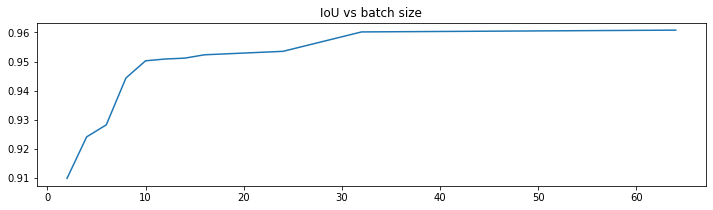

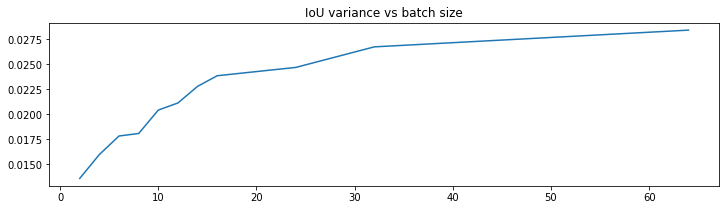

In [42]:
plt.figure(figsize=(12,3))
plt.plot(results[:,0], results[:,1])
plt.title('IoU vs batch size');

plt.figure(figsize=(12,3))
plt.plot(results[:,0], results[:,2])
plt.title('IoU variance vs batch size');

Разброс ошибки возрастает одновременно с IoU, как выбрать BS?

Идея: для всех кадров, которые сеть не видела, делаем отдельный генератор, и делаем предикты этих кадров со всеми весами для всех BS. Затем вычислим ошибку как (отношение ошибочных пикселей к общему числу пикселей) **в прямоугольном кропе** размером 100х512, и посмотрим, для какого BS ошибка минимальна.

Все предикты раскладываем в папку images в папки с номерами сэмплов, чтобы глазами отсмотреть.

### Get best BS on val+test

In [ ]:
figsize=(18,3)

model = ldm_net(X.shape[1], learning_rate=0, loss=tversky_loss, metrics=['mse', MeanIoU(num_classes=2), IoU_var])
unseen_generator = BatchGenerator(X, y, np.hstack((val_indices, test_indices)), batch_size=1, Xdim=X[0].shape, ydim=y[0].shape)

bs = np.zeros((len(unseen_generator)))

for sample,_ in enumerate(unseen_generator):

    X_test, y_test = unseen_generator[sample]
    X_test = np.expand_dims(X_test[0], 0)
    y_test = np.expand_dims(y_test[0], 0) 

    plt.figure(figsize=figsize)
    plt.title('y_true')
    plt.matshow((y_test[0,:,:,0])[200:300,:],0)
    
    if not os.path.exists(Path('images', str(sample))): os.mkdir(Path('images', str(sample)))
    plt.savefig(Path('images',str(sample), '00_y_true.jpg'))
    
    min_err_rate = 1
    min_err_bs   = 0

    for f in os.listdir('weights'): 

        if '.h5' in f and 'Exp' in f: 
            model.load_weights(str(Path("./weights",f)))        
            f = f.split(' ')[1][:5]       
            y_pred = model.predict(X_test)                
            fig, axs = plt.subplots(1, 2, figsize=figsize)               
            axs[0].matshow(y_pred[0,:,:,0][200:300,:])
            y_pred[0,:,:,0][y_pred[0,:,:,0]>0.05]=1
            y_pred[0,:,:,0][y_pred[0,:,:,0]<=0.05]=0
            axs[1].matshow((y_pred[0,:,:,0]-y_test[0,:,:,0])[200:300,:])

            err_rate = np.sum(np.abs((y_pred[0,:,:,0]-y_test[0,:,:,0])[200:300]))/np.sum(np.ones_like((y_pred[0,:,:,0]-y_test[0,:,:,0])[200:300]))
            min_err_rate = min(min_err_rate, err_rate)
            if min_err_rate==err_rate: min_err_bs=f.replace('_','')

            fig.suptitle(f+', error_rate: '+str(err_rate)[:5], fontsize=16) 
            fig.savefig(Path('images',str(sample), f+'.jpg'));
            
            del fig, axs
            plt.show();
            
            plt.close('all');

    if sample in range(0,200,25): print(sample,':: Best batch_size:' , min_err_bs, 'with err_rate =', str(min_err_rate)[:6])
    bs[sample] = int(min_err_bs.split('=')[1])

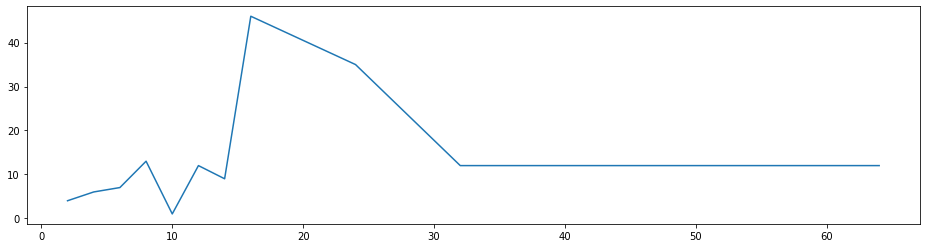

In [44]:
plt.figure(figsize=(16,4))
plt.plot(np.unique(bs, return_counts=True)[0],np.unique(bs, return_counts=True)[1]);

In [45]:
print('Best BS =',int(np.unique(bs, return_counts=True)[0][np.argmax(np.unique(bs, return_counts=True)[1])]))

Best BS = 16


В итоге выходит, что наилучшие размеры батча: от 16 до 24, визуально так и есть, причем выходит, что 16 лучше - более чёткий контур и хвостик. 

Повторяем упражнения с размерами батча от 12 до 26 с шагом 2.

### Second train with BS=12...26

*Exp 2*

In [3]:
for batch_size in [12,14,16,18,20,22,24,26]:
    
    n_epochs=10000
    lr=1e-3
    verbose=0
    res_dict = {}

    model = ldm_net(X.shape[1], learning_rate=lr, loss=tversky_loss, metrics=['mse', MeanIoU(num_classes=2), IoU_var])
    
    train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
    val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
    test_generator  = BatchGenerator(X, y, test_indices, batch_size=1, Xdim=X[0].shape, ydim=y[0].shape, shuffle=False)
    
    early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=verbose)
    lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=10, factor=0.2, patience=10, verbose=verbose, mode='min')
    
    history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                                 epochs=n_epochs, callbacks=[early_stop, lr_reduce],#, m_save],                              
                                 verbose=verbose, workers=1, use_multiprocessing=False)
    
    for key in history.history.keys():
        if 'val_mean_io_u' in key: break  
            
    best_epoch = np.argmin(history.history['loss'])
    
    res_dict[batch_size] = history.history
    
    print('BS=%i, epochs=%i' %(batch_size, len(history.epoch)))
    print("val_MSE: %2.2e, val_IoU: %2.2e, val_IoU_var: %2.2e" % ((history.history['val_mse'][best_epoch]), history.history[key][best_epoch], history.history['val_IoU_var'][best_epoch]))
    print('---------------------------------------------------------')
    
    # save history and weights
    r_name = 'Exp2 BS='+str(batch_size)+"_"+(str(datetime.now())[:16]).replace(':','-')
    model.save_weights(str(Path('weights', r_name+'.h5')))
    save_pkl(res_dict, Path('weights', r_name+'.pkl'))

BS=12, epochs=431
val_MSE: 4.01e-03, val_IoU: 9.54e-01, val_IoU_var: 1.42e-02
---------------------------------------------------------
BS=14, epochs=315
val_MSE: 5.24e-03, val_IoU: 9.40e-01, val_IoU_var: 2.11e-02
---------------------------------------------------------
BS=16, epochs=341
val_MSE: 3.84e-03, val_IoU: 9.56e-01, val_IoU_var: 2.75e-02
---------------------------------------------------------
BS=18, epochs=336
val_MSE: 3.74e-03, val_IoU: 9.56e-01, val_IoU_var: 1.52e-02
---------------------------------------------------------
BS=20, epochs=396
val_MSE: 4.22e-03, val_IoU: 9.52e-01, val_IoU_var: 1.56e-02
---------------------------------------------------------
BS=22, epochs=256
val_MSE: 7.57e-03, val_IoU: 9.20e-01, val_IoU_var: 2.22e-02
---------------------------------------------------------
BS=24, epochs=263
val_MSE: 3.72e-03, val_IoU: 9.57e-01, val_IoU_var: 1.71e-02
---------------------------------------------------------
BS=26, epochs=222
val_MSE: 5.76e-03, val_IoU: 9.

In [6]:
results = np.zeros((8,3))
n_rec=0
for fname in os.listdir('weights'): 
    if '.pkl' in fname and 'Exp2' in fname:
        bs = int(((fname.split(' ')[1][:5]).split("=")[1][:2]).replace('_',''))
        res_dict = load_pkl(Path('weights', fname))
        for key in (res_dict[bs]).keys():
            if 'val_mean_io_u' in key: break
        best_ep = np.argmax(res_dict[bs][key])
#         print(best_ep)
        best_ep = np.argmin(res_dict[bs]['val_loss'])
#         print(best_ep)
#         print('---------------')
        results[n_rec,:] = bs, res_dict[bs][key][best_ep], res_dict[bs]['val_IoU_var'][best_ep]
        n_rec+=1#print(bs, '::', res_dict[bs][key][best_ep], res_dict[bs]['val_IoU_var'][best_ep])   # res_dict[bs]['val_mse'][best_ep],      
results.sort(axis=0)

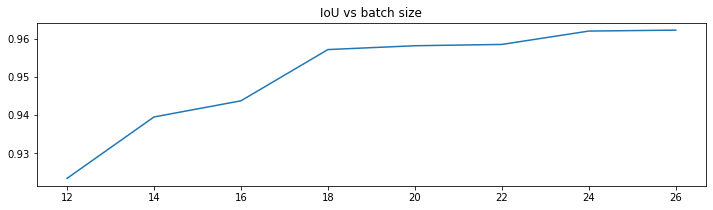

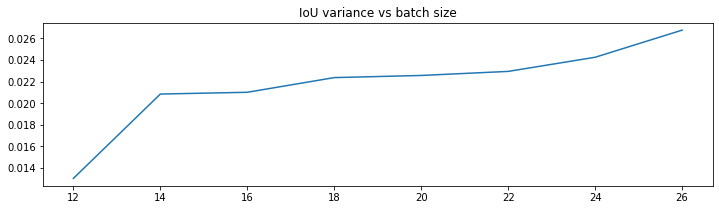

In [7]:
plt.figure(figsize=(12,3))
plt.plot(results[:,0], results[:,1])
plt.title('IoU vs batch size');

plt.figure(figsize=(12,3))
plt.plot(results[:,0], results[:,2])
plt.title('IoU variance vs batch size');

In [ ]:
figsize=(18,3)

model = ldm_net(X.shape[1], learning_rate=0, loss=tversky_loss, metrics=['mse', MeanIoU(num_classes=2), IoU_var])
unseen_generator = BatchGenerator(X, y, np.hstack((val_indices, test_indices)), batch_size=1, Xdim=X[0].shape, ydim=y[0].shape)

bs = np.zeros((len(unseen_generator)))

for sample,_ in enumerate(unseen_generator):

    X_test, y_test = unseen_generator[sample]
    X_test = np.expand_dims(X_test[0], 0)
    y_test = np.expand_dims(y_test[0], 0) 

    plt.figure(figsize=figsize)
    plt.title('y_true')
    plt.matshow((y_test[0,:,:,0])[200:300,:],0)
    
    if not os.path.exists(Path('images', str(sample))): os.mkdir(Path('images', str(sample)))
    plt.savefig(Path('images',str(sample), '00_y_true.jpg'))
    
    min_err_rate = 1
    min_err_bs   = 0

    for f in os.listdir('weights'): 

        if '.h5' in f and 'Exp2' in f: 
            model.load_weights(str(Path("./weights",f)))        
            f = f.split(' ')[1][:5]       
            y_pred = model.predict(X_test)                
            fig, axs = plt.subplots(1, 2, figsize=figsize)               
            axs[0].matshow(y_pred[0,:,:,0][200:300,:])
            y_pred[0,:,:,0][y_pred[0,:,:,0]>0.05]=1
            y_pred[0,:,:,0][y_pred[0,:,:,0]<=0.05]=0
            axs[1].matshow((y_pred[0,:,:,0]-y_test[0,:,:,0])[200:300,:])

            err_rate = np.sum(np.abs((y_pred[0,:,:,0]-y_test[0,:,:,0])[200:300]))/np.sum(np.ones_like((y_pred[0,:,:,0]-y_test[0,:,:,0])[200:300]))
            min_err_rate = min(min_err_rate, err_rate)
            if min_err_rate==err_rate: min_err_bs=f.replace('_','')

            fig.suptitle(f+', error_rate: '+str(err_rate)[:5], fontsize=16) 
            fig.savefig(Path('images',str(sample), f+'.jpg'));
            
            del fig, axs
            plt.show();
            
            plt.close('all');

    if sample in range(0,200,25): print(sample,':: Best batch_size:' , min_err_bs, 'with err_rate =', str(min_err_rate)[:6])
    bs[sample] = int(min_err_bs.split('=')[1])

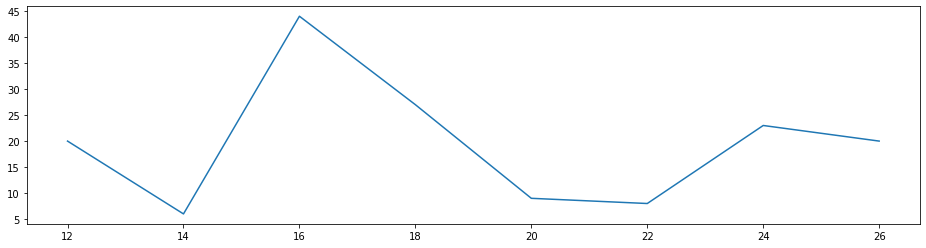

In [9]:
plt.figure(figsize=(16,4))
plt.plot(np.unique(bs, return_counts=True)[0],np.unique(bs, return_counts=True)[1]);

In [10]:
print('Best BS =',int(np.unique(bs, return_counts=True)[0][np.argmax(np.unique(bs, return_counts=True)[1])]))

Best BS = 16


## Hаилучший batch_size=16, получаем веса

Без сплита train-val-test, обучаем на всех имеющихся профилях

In [5]:
n_epochs   = 10000
batch_size = 16
lr         = 1e-3
verbose    = 1
res_dict   = {}

model = ldm_net(X.shape[1], learning_rate=lr, loss=tversky_loss, metrics=['mse', MeanIoU(num_classes=2), IoU_var])

generator = BatchGenerator(X, y, np.hstack((train_indices, val_indices, test_indices)), batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
# val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size, Xdim=X[0].shape, ydim=y[0].shape)
# test_generator  = BatchGenerator(X, y, test_indices, batch_size=1, Xdim=X[0].shape, ydim=y[0].shape, shuffle=False)

early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=verbose)
lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=10, factor=0.2, patience=10, verbose=verbose, mode='min')

history = model.fit_generator(generator=generator, #validation_data=val_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce],#, m_save],                              
                             verbose=verbose, workers=1, use_multiprocessing=False)

for key in history.history.keys():
    if 'val_mean_io_u' in key: break  

best_epoch = np.argmin(history.history['loss'])

res_dict[batch_size] = history.history

# save history and weights
r_name = 'Final weights for 512x512 with Tversky loss and BS='+str(batch_size)+" "+(str(datetime.now())[:16]).replace(':','-')
model.save_weights(str(Path('weights', r_name+'.h5')))
save_pkl(res_dict, Path('weights', r_name+'.pkl'))

Epoch 1/10000
39/39 [==============================] - 18s 452ms/step - loss: 0.8832 - mse: 0.2341 - mean_io_u_1: 0.4772 - IoU_var: 0.0015
Epoch 2/10000
39/39 [==============================] - 17s 446ms/step - loss: 0.8222 - mse: 0.1989 - mean_io_u_1: 0.7628 - IoU_var: 0.0073
Epoch 3/10000
39/39 [==============================] - 17s 425ms/step - loss: 0.8069 - mse: 0.1707 - mean_io_u_1: 0.8215 - IoU_var: 0.0154
Epoch 4/10000
39/39 [==============================] - 17s 423ms/step - loss: 0.7901 - mse: 0.1424 - mean_io_u_1: 0.8135 - IoU_var: 0.0168
Epoch 5/10000
39/39 [==============================] - 17s 426ms/step - loss: 0.7597 - mse: 0.1085 - mean_io_u_1: 0.8004 - IoU_var: 0.0168
Epoch 6/10000
39/39 [==============================] - 17s 426ms/step - loss: 0.6819 - mse: 0.0703 - mean_io_u_1: 0.7747 - IoU_var: 0.0145
Epoch 7/10000
39/39 [==============================] - 16s 420ms/step - loss: 0.4420 - mse: 0.0563 - mean_io_u_1: 0.7436 - IoU_var: 0.0105
Epoch 8/10000
39/39 [======

39/39 [==============================] - 18s 457ms/step - loss: 0.0466 - mse: 0.0041 - mean_io_u_1: 0.9530 - IoU_var: 0.0201
Epoch 117/10000
39/39 [==============================] - 18s 458ms/step - loss: 0.0463 - mse: 0.0041 - mean_io_u_1: 0.9531 - IoU_var: 0.0203
Epoch 118/10000
39/39 [==============================] - 18s 469ms/step - loss: 0.0463 - mse: 0.0041 - mean_io_u_1: 0.9533 - IoU_var: 0.0198
Epoch 119/10000
39/39 [==============================] - 18s 456ms/step - loss: 0.0463 - mse: 0.0040 - mean_io_u_1: 0.9531 - IoU_var: 0.0196
Epoch 120/10000
39/39 [==============================] - 18s 459ms/step - loss: 0.0462 - mse: 0.0040 - mean_io_u_1: 0.9533 - IoU_var: 0.0198
Epoch 121/10000
39/39 [==============================] - 18s 455ms/step - loss: 0.0455 - mse: 0.0040 - mean_io_u_1: 0.9540 - IoU_var: 0.0206
Epoch 122/10000
39/39 [==============================] - 18s 454ms/step - loss: 0.0452 - mse: 0.0040 - mean_io_u_1: 0.9542 - IoU_var: 0.0202
Epoch 123/10000
39/39 [======

39/39 [==============================] - 18s 473ms/step - loss: 0.0327 - mse: 0.0028 - mean_io_u_1: 0.9663 - IoU_var: 0.0202
Epoch 231/10000
39/39 [==============================] - 18s 455ms/step - loss: 0.0322 - mse: 0.0028 - mean_io_u_1: 0.9668 - IoU_var: 0.0199
Epoch 232/10000
39/39 [==============================] - 18s 457ms/step - loss: 0.0322 - mse: 0.0028 - mean_io_u_1: 0.9667 - IoU_var: 0.0196
Epoch 233/10000
39/39 [==============================] - 18s 455ms/step - loss: 0.0324 - mse: 0.0028 - mean_io_u_1: 0.9668 - IoU_var: 0.0194
Epoch 234/10000
39/39 [==============================] - 18s 454ms/step - loss: 0.0323 - mse: 0.0028 - mean_io_u_1: 0.9667 - IoU_var: 0.0201
Epoch 235/10000
39/39 [==============================] - 18s 456ms/step - loss: 0.0322 - mse: 0.0028 - mean_io_u_1: 0.9668 - IoU_var: 0.0201
Epoch 236/10000
39/39 [==============================] - 18s 454ms/step - loss: 0.0323 - mse: 0.0028 - mean_io_u_1: 0.9667 - IoU_var: 0.0202
Epoch 237/10000
39/39 [======

39/39 [==============================] - 18s 454ms/step - loss: 0.0268 - mse: 0.0023 - mean_io_u_1: 0.9720 - IoU_var: 0.0198
Epoch 342/10000
39/39 [==============================] - 18s 466ms/step - loss: 0.0265 - mse: 0.0023 - mean_io_u_1: 0.9722 - IoU_var: 0.0187
Epoch 343/10000
39/39 [==============================] - 18s 465ms/step - loss: 0.0266 - mse: 0.0023 - mean_io_u_1: 0.9721 - IoU_var: 0.0202
Epoch 344/10000
39/39 [==============================] - 18s 468ms/step - loss: 0.0265 - mse: 0.0023 - mean_io_u_1: 0.9722 - IoU_var: 0.0204
Epoch 345/10000
39/39 [==============================] - 18s 456ms/step - loss: 0.0269 - mse: 0.0023 - mean_io_u_1: 0.9721 - IoU_var: 0.0198
Epoch 346/10000
39/39 [==============================] - 18s 453ms/step - loss: 0.0269 - mse: 0.0023 - mean_io_u_1: 0.9720 - IoU_var: 0.0200
Epoch 347/10000
39/39 [==============================] - 18s 452ms/step - loss: 0.0271 - mse: 0.0023 - mean_io_u_1: 0.9718 - IoU_var: 0.0197
Epoch 348/10000
39/39 [======

Epoch 395/10000
39/39 [==============================] - 18s 451ms/step - loss: 0.0267 - mse: 0.0023 - mean_io_u_1: 0.9721 - IoU_var: 0.0201
Epoch 396/10000
39/39 [==============================] - 17s 441ms/step - loss: 0.0270 - mse: 0.0023 - mean_io_u_1: 0.9719 - IoU_var: 0.0198
Epoch 397/10000
39/39 [==============================] - 17s 440ms/step - loss: 0.0269 - mse: 0.0023 - mean_io_u_1: 0.9719 - IoU_var: 0.0205
Epoch 398/10000
39/39 [==============================] - 17s 448ms/step - loss: 0.0265 - mse: 0.0023 - mean_io_u_1: 0.9723 - IoU_var: 0.0200
Epoch 399/10000
39/39 [==============================] - 17s 446ms/step - loss: 0.0270 - mse: 0.0023 - mean_io_u_1: 0.9720 - IoU_var: 0.0192
Epoch 400/10000
39/39 [==============================] - 17s 447ms/step - loss: 0.0267 - mse: 0.0023 - mean_io_u_1: 0.9720 - IoU_var: 0.0201
Epoch 401/10000
39/39 [==============================] - 17s 441ms/step - loss: 0.0271 - mse: 0.0023 - mean_io_u_1: 0.9718 - IoU_var: 0.0198
Epoch 402/100